### Notebook for the photometry of V0628Ori


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Load individual files for each survey (already corrected for internal offsets)


In [2]:
asas_sn = pd.read_csv('asas_sn_corr.csv')
atlas = pd.read_csv('atlas_corr.csv')
crts = pd.read_csv('crts_corr.csv')
aavso = pd.read_csv('aavso_corr.csv')
ptf = pd.read_csv('ptf_corr.csv')
ztf = pd.read_csv('ztf_corr.csv')
asas = pd.read_csv('asas_0.csv') # mag_0 aperture

<IPython.core.display.Javascript object>


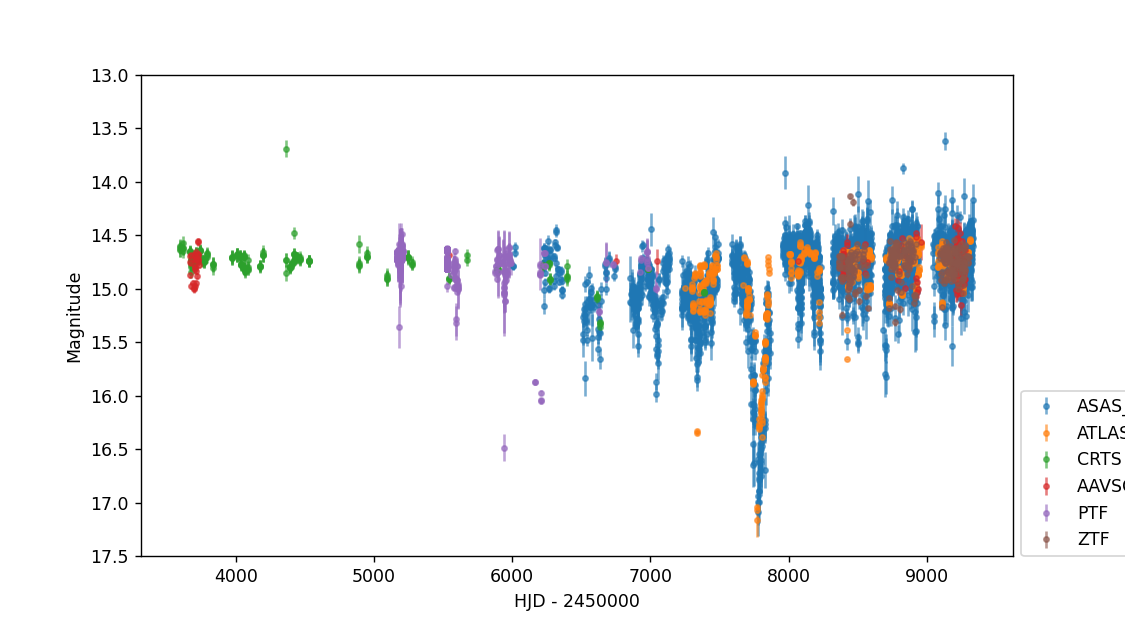

In [3]:
%matplotlib notebook
eclipse = 8000

def baseline(df, eclipse=None):
    if eclipse != None:
        df_baseline = np.nanmedian(df[df['HJD']>eclipse]['mag']) 
    else:
        df_baseline = np.nanmedian(df['mag'])
    return df_baseline

        
        
asas_sn_baseline = baseline(asas_sn, eclipse=eclipse)
atlas_baseline = baseline(atlas, eclipse=eclipse)
aavso_baseline = baseline(aavso, eclipse=None)
crts_baseline = baseline(crts, eclipse=None)
ptf_baseline= baseline(ptf, eclipse=None)
ztf_baseline = baseline(ztf, eclipse=None)
asas_baseline = baseline(asas, eclipse=None)

def merge_asas_sn(df, asas_sn_bl, survey_bl):
    offset = asas_sn_bl - survey_bl
    df_merge = df.copy()
    df_merge['mag'] = df['mag'] + offset
    return df_merge
    
    
# offset = asas_sn_baseline - df_atlas_baseline
# df_atlas_corr_merge = df_atlas_corr.copy()
# df_atlas_corr_merge['mag'] = df_atlas_corr['mag'] + offset


atlas_merge = merge_asas_sn(atlas, asas_sn_baseline, atlas_baseline)
aavso_merge = merge_asas_sn(aavso, asas_sn_baseline, aavso_baseline)
crts_merge = merge_asas_sn(crts, asas_sn_baseline, crts_baseline)
ptf_merge = merge_asas_sn(ptf, asas_sn_baseline, ptf_baseline)
ztf_merge = merge_asas_sn(ztf, asas_sn_baseline, ztf_baseline)
asas_merge = merge_asas_sn(asas, asas_baseline, ztf_baseline)

fig, ax = plt.subplots(1, figsize=(9,5))

def plot_lc(df, ax=None,**kwargs):
    time_corr = df['HJD'] - 2450000 # transform HDJ date
    
    ax = ax or plt.gca()
    
    ax.errorbar(time_corr, df['mag'], df['mag_err'], fmt='.', alpha=0.6, **kwargs)
    return ax

# lc_sp_corr = band_offset(lc_sp, y='mag')
_ = plot_lc(asas_sn, ax=ax, label='ASAS_SN')
_ = plot_lc(atlas_merge, ax=ax, label='ATLAS')
_ = plot_lc(crts_merge,  ax=ax, label='CRTS')
_ = plot_lc(aavso_merge, ax=ax, label='AAVSO')
_ = plot_lc(ptf_merge, ax=ax, label='PTF')
_ = plot_lc(ztf_merge, ax=ax, label='ZTF')
# _ = plot_lc(asas_merge, ax=ax, label='ASAS') # Needs to be properly realigned

# ax.plot(df_tess['HJD'], df_tess['flux'], '.', label='TESS')
# ax.set_title('GAIA_ID = ' + name)
ax.set_ylim(17.5,13)
ax.legend(loc=(1.01,0))
ax.set_ylabel('Magnitude')
ax.set_xlabel('HJD - 2450000')
plt.show()

### SED Photometry
From VizieR we obtain the SED curve

<IPython.core.display.Javascript object>


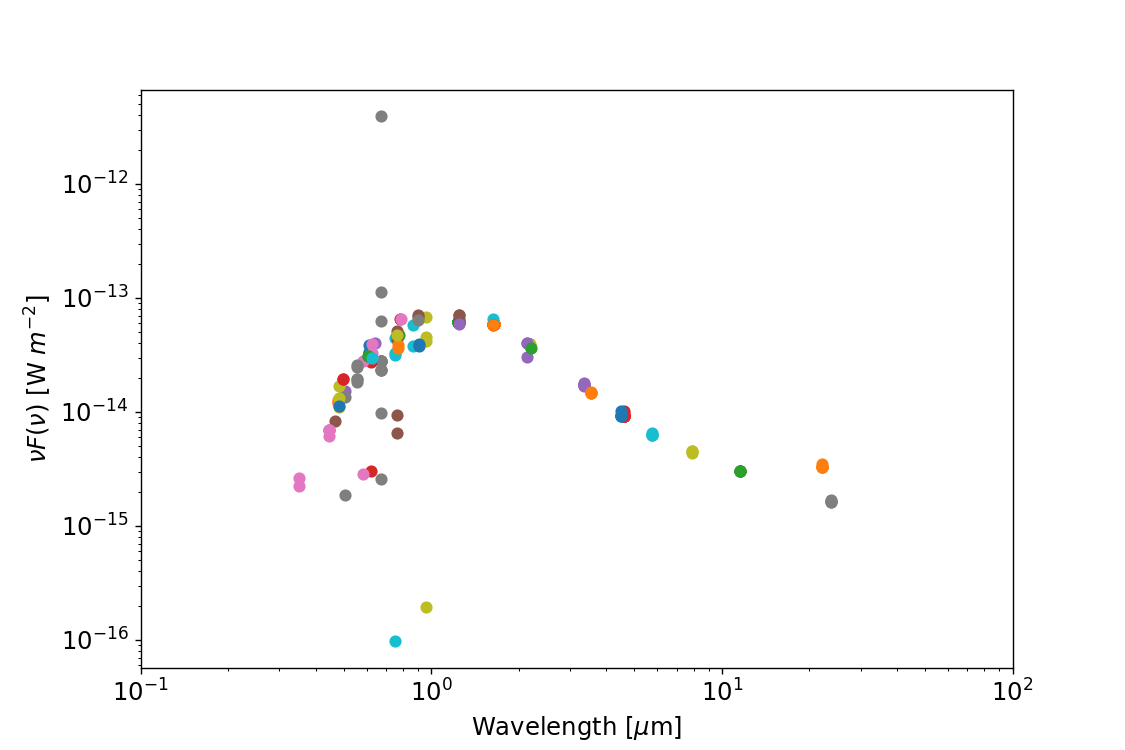

In [8]:
from astropy.io.votable import parse
import scipy.constants as sp
import matplotlib as mpl
mpl.rcParams['font.size'] = 14



votable = parse("./gdr2_30169/vizier_votable.vot")
table = votable.get_first_table().to_table()
table.colnames
df = table.to_pandas()
df['wl'] =  (sp.c / (df['sed_freq']*1e9)) * 1e6 # in micrometers

fig, ax = plt.subplots(1, figsize=(9,6))

# ax.plot(df['wl'], df['sed_freq'] * df['sed_flux'], '.')
ax.set_yscale('log'), ax.set_xscale('log')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'$\nu F(\nu)$ [W $m^{-2}$]')
ax.set_xlim(left=0.1, right=100)

len(df['sed_filter'].unique())

def sed_filter(df,f,ax=None):
    df_temp = df[df['sed_filter']==f]
    
    ax = ax or plt.gca()
    ax.scatter(df_temp['wl'],df_temp['sed_freq']*1e9 * df_temp['sed_flux']*1e-26)
    return ax

for f in df['sed_filter'].unique():
    _ = sed_filter(df, f, ax=ax)

plt.show()